# Machine Learning Package
## &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; - 20PT03, 20PT38, 20PT39

### Importing necessary libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from pandas import read_csv, DataFrame
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM
from keras.utils import to_categorical
import os

### Loading the data

In [2]:
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix+name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix+group+'/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix+'HARDataset/')
    print(trainX.shape, trainy.shape)
    testX, testy = load_dataset_group('test', prefix+'HARDataset/')
    print(testX.shape, testy.shape)
    trainy = trainy - 1
    testy = testy - 1
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    return trainX, trainy, testX, testy

### Checking the balance of each activity

In [3]:
def class_breakdown(data):
    df = DataFrame(data)
    counts = df.groupby(0).size()
    counts = counts.values
    for i in range(len(counts)):
        percent = counts[i]/len(df)*100
        print('Class = %d, Total = %d, Percentage = %.3f'%(i+1, counts[i], percent))

trainy = load_file('HARDataset/train/y_train.txt')
print('Train Dataset')
class_breakdown(trainy)

testy = load_file('HARDataset/test/y_test.txt')
print('\nTest Dataset')
class_breakdown(testy)

Train Dataset
Class = 1, Total = 1226, Percentage = 16.676
Class = 2, Total = 1073, Percentage = 14.595
Class = 3, Total = 986, Percentage = 13.411
Class = 4, Total = 1286, Percentage = 17.492
Class = 5, Total = 1374, Percentage = 18.689
Class = 6, Total = 1407, Percentage = 19.138

Test Dataset
Class = 1, Total = 496, Percentage = 16.831
Class = 2, Total = 471, Percentage = 15.982
Class = 3, Total = 420, Percentage = 14.252
Class = 4, Total = 491, Percentage = 16.661
Class = 5, Total = 532, Percentage = 18.052
Class = 6, Total = 537, Percentage = 18.222


### Plotting the time series data for any one subject

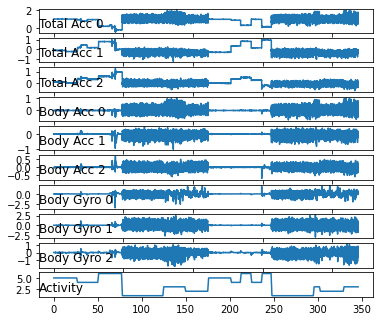

In [4]:
def data_for_subject(X, y, sub_map, sub_id):
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    return X[ix, :, :], y[ix]

def to_series(windows):
    series = list()
    for window in windows:
        half = int(len(window)/2) - 1
        for value in window[-half: ]:
            series.append(value)
    return series

def plot_subject(X, y):
    plt.figure()
    n, off = X.shape[2] + 1, 0
    plt.subplots_adjust(bottom=4, top=5)
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('Total Acc '+str(i), y=0, loc='left')
        off += 1
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('Body Acc '+str(i), y=0, loc='left')
        off += 1
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('Body Gyro '+str(i), y=0, loc='left')
        off += 1
    plt.subplot(n, 1, n)
    plt.plot(y)
    plt.title('Activity', y=0, loc = 'left')
    plt.show()

trainX, trainy = load_dataset_group('train', 'HARDataset/')
sub_map = load_file('HARDataset/train/subject_train.txt')
train_subjects = np.unique(sub_map)
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
plot_subject(subX, suby)

### Plotting the histogram per subject

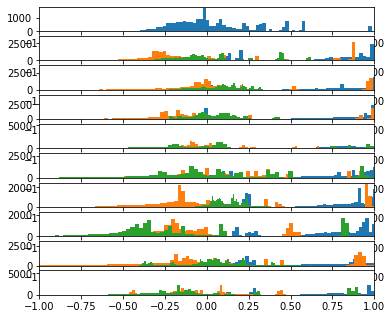

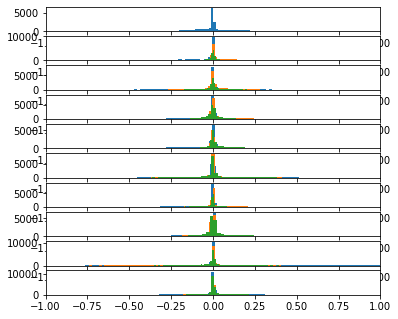

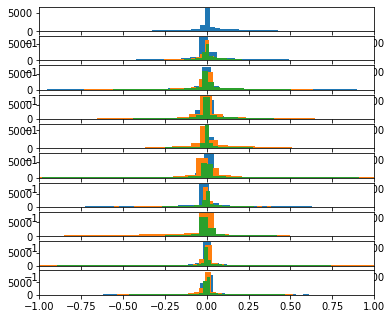

In [5]:
def plot_subject_histograms(X, y, sub_map, j, n=10):
    plt.figure()
    subject_ids = np.unique(sub_map[:, 0])
    xaxis = None
    plt.subplots_adjust(bottom=4, top=5)
    for k in range(n):
        sub_id = subject_ids[k]
        subX, _ = data_for_subject(X, y, sub_map, sub_id)
        for i in range(3):
            ax = plt.subplot(n, 1, k+1, sharex=xaxis)
            ax.set_xlim(-1, 1)
            if k==0:
                xaxis = ax
            plt.hist(to_series(subX[:, :, i+j]), bins=100)
    plt.show()
    

plot_subject_histograms(trainX, trainy, sub_map, 0)
plot_subject_histograms(trainX, trainy, sub_map, 3)
plot_subject_histograms(trainX, trainy, sub_map, 6)

### Plotting histograms for each activity for a subject

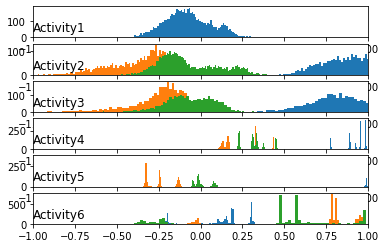

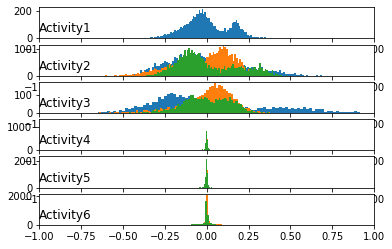

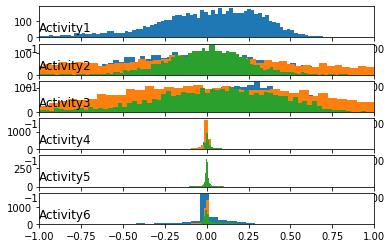

In [6]:
def data_by_activity(X, y, activities):
    return {a:X[y[:, 0]==a, :, :] for a in activities}

def plot_activity_histograms(X, y, j):
    activity_ids = np.unique(y[:, 0])
    grouped = data_by_activity(X, y, activity_ids)
    plt.figure()
    xaxis = None
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        for i in range(3):
            ax = plt.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1, 1)
            if k==0:
                xaxis = ax
            plt.hist(to_series(grouped[act_id][:, :, i+j]), bins=100)
            plt.title('Activity'+str(act_id), y=0, loc='left')
    plt.show()
    
plot_activity_histograms(subX, suby, 0)
plot_activity_histograms(subX, suby, 3)
plot_activity_histograms(subX, suby, 6)

### LSTM network model

In [7]:
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 15, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    return accuracy

def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)'%(m, s))

def run_experiment(repeats=10):
    trainX, trainy, testX, testy = load_dataset()
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score*100.0
        print('>#%d: %.3f'%(r+1, score))
        scores.append(score)
    summarize_results(scores)
    
run_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
>#1: 91.245
>#2: 90.363
>#3: 91.890
>#4: 91.279
>#5: 89.990
>#6: 92.060
>#7: 89.413
>#8: 90.193
>#9: 91.653
>#10: 87.852
[91.24533534049988, 90.3630793094635, 91.89005494117737, 91.27926826477051, 89.98982310295105, 92.05971956253052, 89.41296339035034, 90.19341468811035, 91.65253043174744, 87.85205483436584]
Accuracy: 90.594% (+/-1.238)


### Calculating the confusion matrix and normalized confusion matrix

In [32]:
def run_experiment(repeats=10):
    trainX, trainy, testX, testy = load_dataset()
    for r in range(repeats):
        prob = evaluate_model(trainX, trainy, testX, testy)
        print(prob.shape)
        return prob
    
output = run_experiment(1)
indexes = tf.argmax(output, axis=1) + 1
testy = load_file('HARDataset/test/y_test.txt')
confusion_matrix = metrics.confusion_matrix(testy, indexes)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
93/93 [==============================] - 6s 50ms/step
(2947, 6)


In [36]:
print('Confusion matrix: \n', confusion_matrix)
print('\nNormalized confusion matrix: \n', normalised_confusion_matrix)

output

Confusion matrix: 
 [[461  29   6   0   0   0]
 [  1 469   0   0   1   0]
 [  0  16 404   0   0   0]
 [  1   2   0 375 113   0]
 [  1   0   0  82 449   0]
 [  0  27   0   0   0 510]]

Normalized confusion matrix: 
 [[15.643027    0.9840515   0.20359688  0.          0.          0.        ]
 [ 0.03393281 15.91449     0.          0.          0.03393281  0.        ]
 [ 0.          0.542925   13.708857    0.          0.          0.        ]
 [ 0.03393281  0.06786563  0.         12.724805    3.8344078   0.        ]
 [ 0.03393281  0.          0.          2.7824907  15.235832    0.        ]
 [ 0.          0.916186    0.          0.          0.         17.305735  ]]


array([[8.4340325e-05, 5.6741475e-05, 4.0743985e-06, 6.2910490e-02,
        9.3693924e-01, 5.0963022e-06],
       [7.0150272e-05, 4.7364443e-05, 3.1263276e-06, 5.8121234e-02,
        9.4175422e-01, 3.9719530e-06],
       [6.6946566e-05, 4.4526969e-05, 2.8677098e-06, 5.6915984e-02,
        9.4296604e-01, 3.5965775e-06],
       ...,
       [1.2421764e-04, 9.9983168e-01, 3.9545444e-05, 6.1447804e-07,
        1.3774351e-06, 2.6141120e-06],
       [7.6568758e-05, 9.9988282e-01, 2.5188365e-05, 1.1236677e-06,
        1.6959110e-06, 1.2581068e-05],
       [3.9363917e-05, 9.9991333e-01, 2.4179379e-05, 6.5622760e-07,
        1.4627030e-06, 2.0929039e-05]], dtype=float32)

### Plotting the confusion matrix

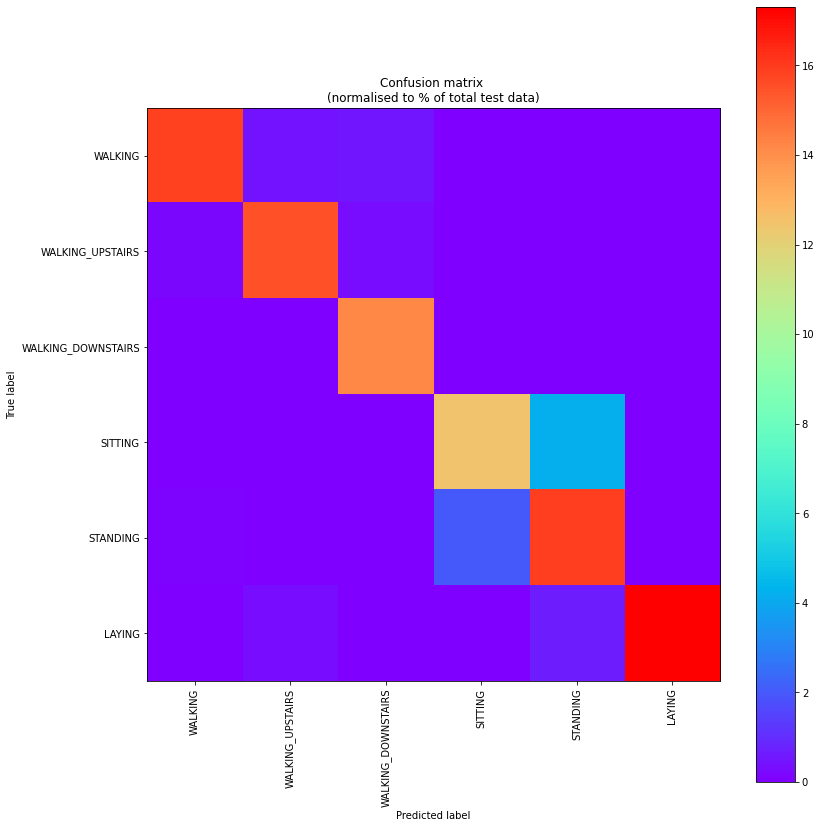

In [29]:
n_classes = 6
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()